In [14]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import os
import time
import copy
import pickle

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import glob
import random

In [2]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [38]:
# Script runtime options
model_name = 'resnet152'
model_func = models.resnet152
root_dir = '../data'
data_dir = os.path.join(root_dir,'species_dataset')
working_dir = os.path.join('models/classification', model_name)
batch_size = 16
num_workers = 4
num_epochs = 40

In [4]:
# Setup the model and optimiser
model_ft = models.resnet152(pretrained=True)

In [5]:
sp_names = pd.read_csv('/home/ortion/Documents/projects/TensorBird/data/sp_names.csv')
class_names = sp_names["sp_code"]
sp_names


sp_code               sp_latin                 sp_fr
0  cyacae    Cyanistes caeruleus         Mésange bleue
1  parmaj            Parus major  Mésange charbonnière
2  erirub     Erithacus rubecula   Rougegorge familier
3  prumod     Prunella modularis     Accenteur mouchet
4  pasdom      Passer domesticus    Moineau domestique
5  turmer          Turdus merula            Merle noir
6  felcat            Felix catus       Chat domestique
7  fricoe      Fringilla coelebs     Pinson des arbres
8  stedec  Streptopelia decaocto    Tourterelle turque
9  carcar    Carduelis carduelis  Chardonneret élégant

In [44]:
# Setup transformations
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(data_dir)
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
               for x in ['train', 'test']}

In [6]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

In [7]:
model_ft = model_ft.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
def load_images():
    images_per_class = 10
    validation_rate = 0.2
    X_dataset = []
    y_dataset = []
    
    train_dataset = {'x': [], 'y': []}
    val_dataset = {'x': [], 'y': []}
    
    for sp_code in class_names:
        image_paths = glob.glob(f"../data/species_dataset/{sp_code}/*.jpg")
        for i in range(images_per_class - 1):
            if (i >= len(image_paths)):
                break
            im = Image.open(image_paths[i])
            im = im.resize((100, 75))
            X_dataset.append(np.array(im))
            y_dataset.append(sp_code)
    
    for i in range(int(len(X_dataset) - len(X_dataset) * validation_rate)):
        train_dataset['x'].append(X_dataset[i])
        train_dataset['y'].append(y_dataset[i])
        
    for i in range(int(len(X_dataset) - len(X_dataset) * validation_rate), len(X_dataset) - 1):
        val_dataset['x'].append(X_dataset[i])
        val_dataset['y'].append(y_dataset[i])
    return (train_dataset, val_dataset)

In [10]:
(train_dataset, val_dataset) = load_images()

### Show dataset sample using matplotlib

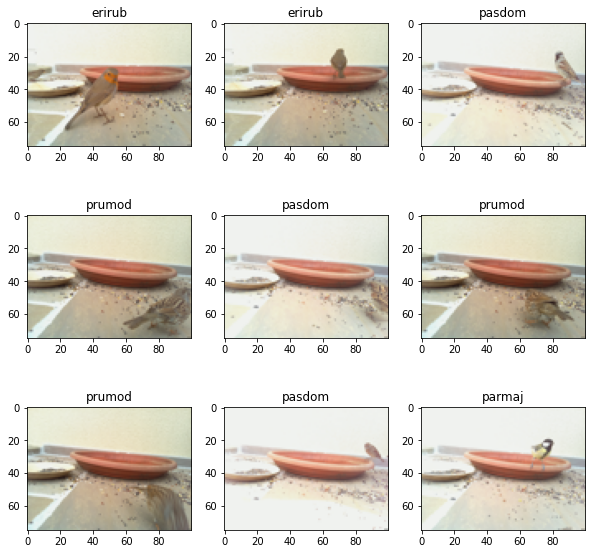

In [26]:
fig = plt.figure(figsize=(10, 10))
rows = 3
cols = 3
axes=[]
for a in range(rows*cols):
    idx = random.randint(a, len(train_dataset['x'])-1)
    b = train_dataset['x'][idx]
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Photo"+str(a))
    axes[-1].set_title(train_dataset['y'][idx])  
    plt.imshow(b)

In [36]:
def train_model(model, criterion, optimizer, scheduler, dataset, device, num_epochs=25,
                return_history=False, log_history=True, working_dir='output'):
    since = time.time()
    best_acc = 0.0
    history = {'epochs': [], 'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    
    for epochs in range(num_epochs):
        print(f"Epoch{epochs}/{num_epochs -1}")
        print('-'*10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
          # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
        if phase == 'train':
            scheduler.step()
            
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        history['epoch'].append(epoch)
        history[phase+'_loss'].append(epoch_loss)
        history[phase+'_acc'].append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    if return_history:
        return model, history
    else:
        return model

In [37]:
dataset = {'train': train_dataset, 'test': val_dataset}
history, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, device, num_epochs=40)

Epoch0/39
----------


AttributeError: 'list' object has no attribute 'to'